<a href="https://colab.research.google.com/github/Gennaro1/AML-project/blob/main/MNIST_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Applied Machine Learning - MNIST Project**

Bioinformatics, University of Bologna

> Gennaro Luciano



The **MNIST** Database (Modified National Institute of Standards and Technology database) is a large database that holds a huge number of images represeting handwritten digits from 0 to 9. The database contains 60,000 training images and 10,000 testing images each of them such as grayscale and a size of 28x28 (784 pixels per image).
The task is to produce a handwriting classifier based on different machine learning classification methods and to analyze the performances of these methods in terms of performance and accuracy. 



In [2]:
#in order to take track of time
from datetime import date, datetime
start=datetime.now()
!pip install ipython-autotime
%load_ext autotime

time: 195 µs (started: 2021-11-25 16:26:56 +00:00)


## Import data
Trough the *Keras library* it is possible to retrieve the entire MNIST dataset. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from keras.datasets import mnist
import seaborn as sns 
import scipy as sp
from scipy.ndimage import interpolation

time: 2.54 s (started: 2021-11-25 16:26:56 +00:00)


In [4]:
# We are loading the dataset and split it into train and test sets 
mist= keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step
time: 640 ms (started: 2021-11-25 16:26:59 +00:00)


### Data analysis 

In [5]:
# Visualize the shape of the train and test sets
print("train_images:",train_images.shape)
print("The number of training labels is:", len(train_labels))
print("test_images:",test_images.shape)
print("The number of testin labels is:",len(test_labels))

train_images: (60000, 28, 28)
The number of training labels is: 60000
test_images: (10000, 28, 28)
The number of testin labels is: 10000
time: 2.13 ms (started: 2021-11-25 16:26:59 +00:00)


When approaching a database, it is very important to familiarize yourself with the data it contains. We are going to inspect the data in the database and analyze the distribution of the classes. 

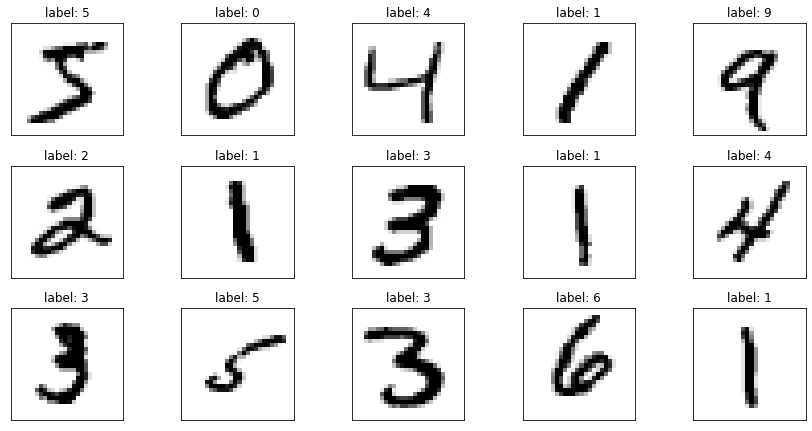

time: 709 ms (started: 2021-11-25 16:26:59 +00:00)


In [6]:
#plotting 15 images of the training dataset and the relative labels
fig, axs = plt.subplots(figsize=(12, 10))

for number in range(15):
  plt.subplot(5, 5, number + 1)
  plt.imshow(train_images[number], cmap='gray_r')
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title(f'label: {train_labels[number]}')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'number of classes')]

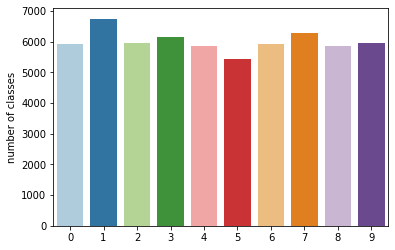

time: 237 ms (started: 2021-11-25 16:27:00 +00:00)


In [7]:
#class distribution for training set
class_distribution_train_plot=sns.countplot(train_labels,palette="Paired")
class_distribution_train_plot.set(ylabel="number of classes")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'number of classes')]

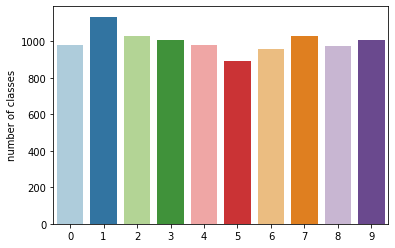

time: 182 ms (started: 2021-11-25 16:27:00 +00:00)


In [8]:
#class distribution for testing set
class_distribution_test_plot=sns.countplot(test_labels,palette="Paired")
class_distribution_test_plot.set(ylabel="number of classes")

## Data manipulation

This is a very important step in any machine learning technique because of the importance to provide readable and suited data to the machine learning process.

For our purposes, it has been exploited the [Deskewing process](https://fsix.github.io/mnist/Deskewing.html).

Deskewing is the process of straightening an image that has been scanned or written crookedly — that is an image that is slanting too far in one direction, or one that is misaligned.

In [9]:
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix
  
def deskew(image):
  c,v = moments(image)
  alpha = v[0,1]/v[0,0]
  affine = np.array([[1,0],[alpha,1]])
  ocenter = np.array(image.shape)/2.0
  offset = c-np.dot(affine,ocenter)
  return interpolation.affine_transform(image,affine,offset=offset)

time: 18.9 ms (started: 2021-11-25 16:27:00 +00:00)


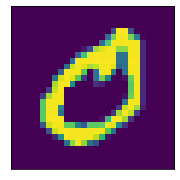

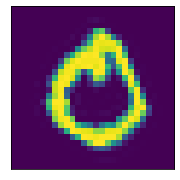

time: 133 ms (started: 2021-11-25 16:27:00 +00:00)


In [10]:
#an example of the Deskwing process 
fig, axs = plt.subplots(figsize=(3,3))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(train_images[21].reshape(28,28))


Desk_im=deskew(train_images[21].reshape(28,28))
fig, axs = plt.subplots(figsize=(3, 3))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(Desk_im)

In [11]:
#at this point, we have to apply this process to our dataset

def deskewAll(train_images):
    currents = []
    for i in range(len(train_images)):
        currents.append(deskew(train_images[i].reshape(28,28)).flatten())
    return np.array(currents)

train_images_deskewed = deskewAll(train_images)
test_images_deskewed = deskewAll(test_images)

time: 25.3 s (started: 2021-11-25 16:27:01 +00:00)


## Decision Tree 

The first technique is based on the generation of a decision tree that represents a supervised machine learning method exploited for both regression and classification. 
A decision tree is represented with a tree structure where each internal node denotes a test on an attribute, each branch represent the outcome of the test and each leaf holds a class label. 


In [12]:
#It is important to reshape the data
from sklearn import tree

train_images=train_images_deskewed.flatten().reshape(60000,784)
test_images=test_images_deskewed.flatten().reshape(10000,784)

#now it is possible to train our model
tree_classifier=tree.DecisionTreeClassifier(max_depth=15)
tree_classifier.fit(train_images,train_labels)

#test 
classifier_predictions= tree_classifier.predict(test_images)


time: 18.1 s (started: 2021-11-25 16:27:26 +00:00)


To evaluate the performance of the model, we are going to calculate several scores that can give us an idea of ​​the quality of the prediction.

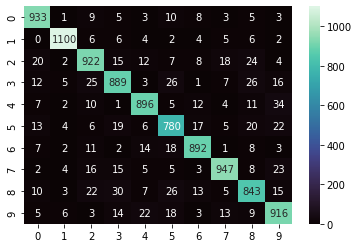

time: 654 ms (started: 2021-11-25 16:27:44 +00:00)


In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score

cf_matrix= confusion_matrix(test_labels,classifier_predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="mako")

The confusion matrix shows that most of the images are correctly classified, but there are still some classification errors. From the matrix, we can deduce that the model tends to mostly misclassify class 4 to class 9. An interpretation of this result can be given by the similarity between the two digits.
As proof of this interpretation, we can also deduce from the matrix that it is more likely to misclassify a class 2 to a class 8 than a class 0 to class 1.

In [14]:
#Now it is possible to compute the accuracy of the classification

Accuracy=accuracy_score(test_labels,classifier_predictions)
print("The accuracy of the prediction is:", Accuracy)

The accuracy of the prediction is: 0.9118
time: 3.26 ms (started: 2021-11-25 16:27:45 +00:00)


The accuracy achieved is about 91%, a good score. However, we are going to increase the accuracy of prediction by exploiting other machine learning classification models. 

# Random Forest

Random forest represents a learning method that operates by constructing a multitude of decision trees that operate as an ensemble.  

This learning method operates by constructing a multitude of decision tree at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.



In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, accuracy_score

time: 272 ms (started: 2021-11-25 16:27:45 +00:00)


The number of trees can influence the performance of the model; because it makes the model more efficient, but at the same time slows down the computation.

In [16]:
#we are going to analyse the performance of the method with different number of trees

number_tree=[10,15,30,50,100]
top_accuracy={}
for number in number_tree:
  model=RandomForestClassifier(n_estimators=number)
  model.fit(train_images,train_labels)
  predictions=model.predict(test_images)
  report=classification_report(test_labels,predictions)
  accuracy=accuracy_score(test_labels,predictions)
  top_accuracy[number]=accuracy
  print("Classification performed with:",number, "trees", '\n',report, '\n', "The accuracy is equal to:", accuracy)

Classification performed with: 10 trees 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.97      0.96      1032
           3       0.95      0.96      0.95      1010
           4       0.95      0.97      0.96       982
           5       0.95      0.95      0.95       892
           6       0.97      0.96      0.97       958
           7       0.97      0.96      0.97      1028
           8       0.95      0.94      0.94       974
           9       0.97      0.93      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000
 
 The accuracy is equal to: 0.9617
Classification performed with: 15 trees 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1 

In [17]:
n_tree_with_high_accuracy=max(top_accuracy, key=top_accuracy.get)
print("The highest accuracy is achivied using", n_tree_with_high_accuracy,"trees")
print("The accuracy is equal to:", top_accuracy[n_tree_with_high_accuracy])

The highest accuracy is achivied using 100 trees
The accuracy is equal to: 0.9771
time: 2.48 ms (started: 2021-11-25 16:29:30 +00:00)


In [18]:
#The next step is to consider the hyperparameters for training and testing our model

model=RandomForestClassifier(n_estimators=n_tree_with_high_accuracy)
model.fit(train_images,train_labels)


RandomForestClassifier()

time: 50.8 s (started: 2021-11-25 16:29:30 +00:00)


In [19]:
f_predictions=model.predict(test_images)

report=classification_report(test_labels,f_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

time: 460 ms (started: 2021-11-25 16:30:21 +00:00)


In [20]:
RF_accuracy=accuracy_score(test_labels,f_predictions)
print("The accuracy is equal to:", RF_accuracy)


The accuracy is equal to: 0.9777
time: 5.6 ms (started: 2021-11-25 16:30:22 +00:00)


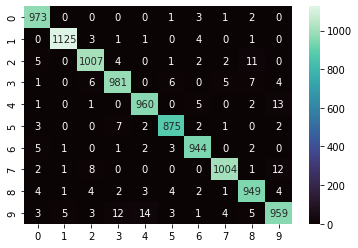

time: 619 ms (started: 2021-11-25 16:30:22 +00:00)


In [21]:
#Now it is possible to compute the confusion matrix

cf_matrix = confusion_matrix(test_labels, f_predictions)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="mako")

Considering the accuracy that is over 97% and the confusion matrix, we can safely assert that Random Forest performed better than a simple Decision tree, as we could expect.

One of the differences between the two confusion matrixes, one for the random forest and one for the decision tree, is the low value of incorrect classification among all the digits.

# CNN 

**Convolutional Neural Network** (CNN) represents a class of a artificial neural network, most commonly applied to analyze visual imagery. 
The input of CNN is a image's raw pixel data. The CNN learns how to extract features and infer what object they constitute. 

The model that we are going to expolit has a double "function": the extraction of the features and the prediction. 

## Data manipulation

In [22]:
#Now we are going to reshape our data
train_images=train_images_deskewed.reshape(train_images_deskewed.shape[0],28,28,1)
test_images=test_images_deskewed.reshape(test_images_deskewed.shape[0],28,28,1)
input_shape=(28,28,1)


time: 3.41 ms (started: 2021-11-25 16:30:22 +00:00)


In [23]:
#normalization of 28x28 greyscale values in order to obtain intensity values of the pixels between 0 and 1
train_images=train_images / 255.0
test_images=test_images / 255.0

time: 186 ms (started: 2021-11-25 16:30:22 +00:00)


In [24]:
#We are going to use binary vectors of 10 elements to represent  unique integers representing our labels
from keras.utils.np_utils import to_categorical

nlabels=10
train_labels_v=to_categorical(train_labels, num_classes=nlabels)
test_labels_v=to_categorical(test_labels, num_classes=nlabels)


time: 5.79 ms (started: 2021-11-25 16:30:22 +00:00)


In [25]:
#lets print an example
print("label: {} ---> vector : {}".format(train_labels[17], train_labels_v[17]))

label: 8 ---> vector : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
time: 5.18 ms (started: 2021-11-25 16:30:22 +00:00)


## Building the model

We need to define the architecture of the model and equip it with an optimizer function, loss function and performance metrics. The architecture is composed by a **2D convolutional layer** with a small filter size and 32 as numbers of filters, followed by a **maxpooling layer**.
We need an output layer able to predict the probability distribution of an image belonging to each of the 10 classes. Will be added between the feature extractor layer and the output layer a dense layer able to interpret the features. Also, we will consider 3 hyperparameters:     


*   **Learning rate**: we will use an optimazer able to adjust the learning rate throughout training.
*   **Loss function**: we will use a categorical_crossentropy as the loss function.
*   **Performance metrics**: we will use an accuracy performance metric in order to obtain the accuracy score to valuate the model. 









In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

time: 3.7 ms (started: 2021-11-25 16:30:22 +00:00)


In [27]:
CNN_model= Sequential()
#All layers will use ReLu activation function
CNN_model.add(Conv2D(32, kernel_size=(3,3), activation = "relu", kernel_initializer="he_uniform", input_shape=(28,28,1)))
CNN_model.add(MaxPool2D(pool_size=(2, 2)))

#We add a flatten layer between the convolutional and dense layer
CNN_model.add(Flatten())

#we add 100 neurons to the Dense layer
CNN_model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))

#we will use softmax as activation function
CNN_model.add(Dense(nlabels, activation='softmax'))

CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 100)               540900    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
__________________________________________________

In [28]:
#compiling the model with the hyperparameters
CNN_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

time: 14.1 ms (started: 2021-11-25 16:30:23 +00:00)


Now we have to deal with other two hyperparameters:

*     **Epochs**: it represents the number of times that the learning algorithm will work on the training dataset. An epoch is comprised of one or more batches.
*     **Batch size**: it represents the number of samples to elaborate on before updating the internal parameters. 



In [29]:
#training the model

epochs=25
batch_size=250

CNN_history = CNN_model.fit(x=train_images, y=train_labels_v, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/25
216/216 [==============================] - 22s 97ms/step - loss: 0.2114 - accuracy: 0.9362 - val_loss: 0.0937 - val_accuracy: 0.9703
Epoch 2/25
216/216 [==============================] - 21s 96ms/step - loss: 0.0688 - accuracy: 0.9793 - val_loss: 0.0490 - val_accuracy: 0.9868
Epoch 3/25
216/216 [==============================] - 21s 96ms/step - loss: 0.0432 - accuracy: 0.9871 - val_loss: 0.0447 - val_accuracy: 0.9872
Epoch 4/25
216/216 [==============================] - 21s 96ms/step - loss: 0.0323 - accuracy: 0.9904 - val_loss: 0.0410 - val_accuracy: 0.9880
Epoch 5/25
216/216 [==============================] - 21s 96ms/step - loss: 0.0243 - accuracy: 0.9930 - val_loss: 0.0382 - val_accuracy: 0.9883
Epoch 6/25
216/216 [==============================] - 21s 96ms/step - loss: 0.0186 - accuracy: 0.9943 - val_loss: 0.0354 - val_accuracy: 0.9902
Epoch 7/25
216/216 [==============================] - 21s 96ms/step - loss: 0.0143 - accuracy: 0.9961 - val_loss: 0.0380 - val_accuracy:

In [30]:
#the next operation is to evaluate the model performance
score=CNN_model.evaluate(test_images,test_labels_v,verbose=0)
CNN_accuracy=score[1]
CNN_test_loss=score[0]
print("Test cross entropy loss :", CNN_test_loss, "\nTest classification Accuracy:", CNN_accuracy)


Test cross entropy loss : 0.035991519689559937 
Test classification Accuracy: 0.9907000064849854
time: 2.15 s (started: 2021-11-25 16:39:45 +00:00)


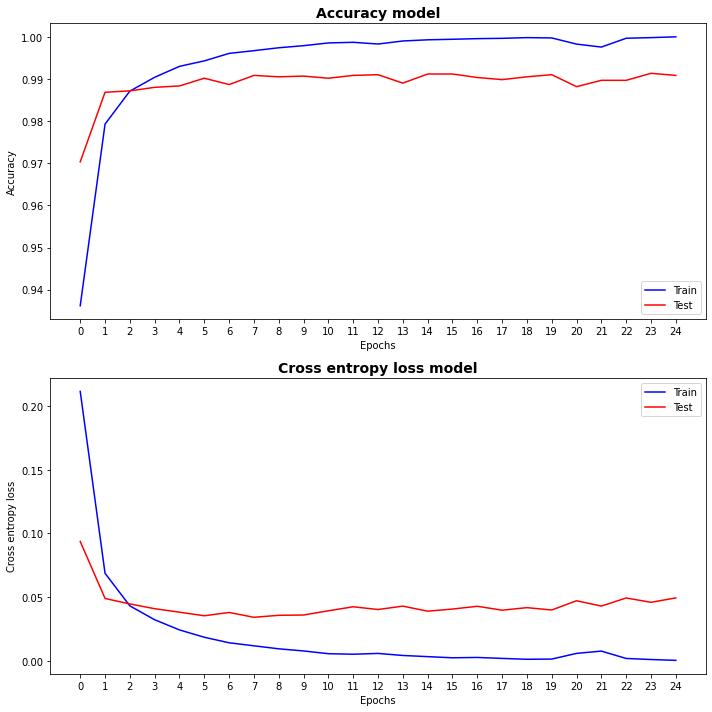

time: 631 ms (started: 2021-11-25 16:39:48 +00:00)


In [31]:
fig = plt.figure(figsize=(10,10)) 
plt.subplot(2,1,1)
plt.plot(CNN_history.history['accuracy'], color="blue")
plt.plot(CNN_history.history['val_accuracy'], color="red")
plt.title('Accuracy model', fontdict={"fontsize":14, "fontweight":"bold"})
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(0,25))
plt.legend(['Train','Test'],loc='lower right')

plt.subplot(2,1,2)
plt.plot(CNN_history.history['loss'], color="blue")
plt.plot(CNN_history.history['val_loss'], color="red")
plt.title('Cross entropy loss model',fontdict={"fontsize":14, "fontweight":"bold"})
plt.ylabel('Cross entropy loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(0,25))
plt.legend(['Train','Test'], loc='upper right')

plt.tight_layout()

As we can see from the graphs, the accuracy, compared to the previous model, increased significantly. 
In the model loss plot, it is possible to observe how rapidly decrease the cross entropy loss on training set, this means that the model learning very fast how to classify the digits. But we can observe also how the model is prone to overfittig, since the train cross entropy loss decrease and test cross entropy loss increase. The overfitting has a negative imapacts on the performance of the model. The test cross entropy loss start to increase since the 2-3° epoch. 

## Improvement of the model



The main idea is to modify the model in order to improve the perfomances and to eliminate the problem of overfitting. To reach these tasks, we are going to add another 2D convolutional layer with 64 filters each and another max pooling layer. 

In [32]:
new_model = Sequential()
new_model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
new_model.add(MaxPool2D(pool_size=2))
new_model.add(Dropout(0.5))
new_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
new_model.add(MaxPool2D(pool_size=2))
new_model.add(Dropout(0.5))
new_model.add(Flatten())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(nlabels, activation='softmax'))

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)         

In [33]:
new_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

epochs=25
batch_size=250

new_CNN_history = new_model.fit(x=train_images, y=train_labels_v, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/25
216/216 [==============================] - 58s 268ms/step - loss: 0.5600 - accuracy: 0.8225 - val_loss: 0.1210 - val_accuracy: 0.9692
Epoch 2/25
216/216 [==============================] - 58s 267ms/step - loss: 0.2003 - accuracy: 0.9380 - val_loss: 0.0675 - val_accuracy: 0.9815
Epoch 3/25
216/216 [==============================] - 57s 266ms/step - loss: 0.1412 - accuracy: 0.9559 - val_loss: 0.0525 - val_accuracy: 0.9848
Epoch 4/25
216/216 [==============================] - 57s 265ms/step - loss: 0.1131 - accuracy: 0.9648 - val_loss: 0.0451 - val_accuracy: 0.9870
Epoch 5/25
216/216 [==============================] - 57s 265ms/step - loss: 0.1020 - accuracy: 0.9670 - val_loss: 0.0373 - val_accuracy: 0.9898
Epoch 6/25
216/216 [==============================] - 57s 265ms/step - loss: 0.0916 - accuracy: 0.9713 - val_loss: 0.0361 - val_accuracy: 0.9887
Epoch 7/25
216/216 [==============================] - 57s 264ms/step - loss: 0.0849 - accuracy: 0.9728 - val_loss: 0.0329 - val_ac

In [34]:
#comparing the new model with the oldest
new_score=new_model.evaluate(test_images,test_labels_v,verbose=0)
new_CNN_accuracy=new_score[1]
new_CNN_test_loss=new_score[0]
print("Model performances:")
print("Test cross entropy loss :", CNN_test_loss, "\nTest classification Accuracy:", CNN_accuracy)
print("\nNew model performances:")
print("Test cross entropy loss :", new_CNN_test_loss, "\nTest classification Accuracy:", new_CNN_accuracy,"\n")

Model performances:
Test cross entropy loss : 0.035991519689559937 
Test classification Accuracy: 0.9907000064849854

New model performances:
Test cross entropy loss : 0.0213153176009655 
Test classification Accuracy: 0.9929999709129333 

time: 3.2 s (started: 2021-11-25 17:03:39 +00:00)


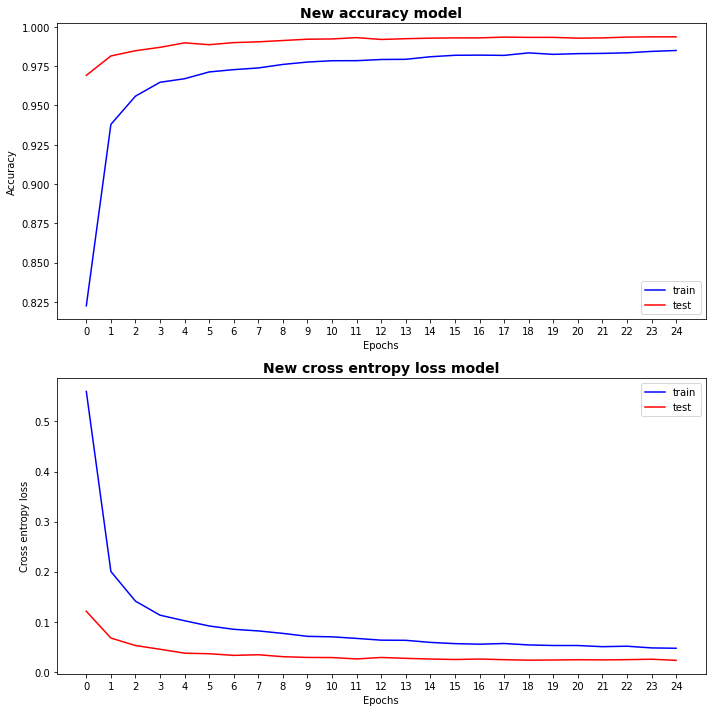

time: 634 ms (started: 2021-11-25 17:03:42 +00:00)


In [35]:
fig = plt.figure(figsize=(10,10)) 
plt.subplot(2,1,1)
plt.plot(new_CNN_history.history['accuracy'], color="blue")
plt.plot(new_CNN_history.history['val_accuracy'], color="red")
plt.title('New accuracy model', fontdict={"fontsize":14, "fontweight":"bold"})
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(0,25))
plt.legend(['train','test'],loc='lower right')

plt.subplot(2,1,2)
plt.plot(new_CNN_history.history['loss'], color="blue")
plt.plot(new_CNN_history.history['val_loss'], color="red")
plt.title('New cross entropy loss model',fontdict={"fontsize":14, "fontweight":"bold"})
plt.ylabel('Cross entropy loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(0,25))
plt.legend(['train','test'], loc='upper right')

plt.tight_layout()

We achieved our goals. The performance of the model improved both as regards the accuracy and as regards the cross entropy loss. We can observe that the cross entropy loss test is lower than the train cross entropy loss along the epochs, contrary to what we saw in the previous model. Another evidence of the improvements made to the model is given by the test accuracy, which has no peaks and is higher than the train accuracy in each epoch.

## Discussion

The aim of the project is to build a  classifier of handwritten figures and test their performance. Several models have been statistically tested in the project, but certainly the most performing is the CNN model which has a higher accuracy than the others, but also makes fewer misclassification errors.
The random forest model also provides excellent performance and is really simple to implement. We must take into consideration that the accuracy values ​​produced by our models have been influenced by the use of the deskewing procedure.





In [39]:
CNN_accuracy= round(CNN_accuracy,3)
new_CNN_accuracy=round(new_CNN_accuracy,3)

print("The accuracy of Decision tree is:", Accuracy)
print("\nThe accuracy of Random forest is:", top_accuracy[n_tree_with_high_accuracy])
print("\nThe accuracy of CNN is:", CNN_accuracy)
print("\nThe accuracy of CNN improved is:", new_CNN_accuracy,"\n")


The accuracy of Decision tree is: 0.9118

The accuracy of Random forest is: 0.9771

The accuracy of CNN is: 0.991

The accuracy of CNN improved is: 0.993 

time: 12.2 ms (started: 2021-11-25 17:32:11 +00:00)


In [37]:
print("The time needed to perform all operations is:",datetime.now()-start)

The time needed to perform all operations is: 0:36:50.608941
time: 3.42 ms (started: 2021-11-25 17:03:43 +00:00)
